# 1週間分のルールを作成するためのprogram  
前件部に重みを付け、ルールの簡略化を目指す

In [295]:
#加工前データ
import xlrd
import pprint
import openpyxl
import numpy as np
from datetime import datetime as dt
import pandas as pd
from sklearn import preprocessing
import copy

In [296]:
bed_data_filename = 'bed_data.csv'
before_csv = 'osaka_data_before.csv'
data_filename = 'osaka_data_before.xlsx'
save_filename = 'before_1week_MA_preW.xlsx'
data_sheet = 'Sheet1'

In [297]:
#開始日と終了日を参照する
df = pd.read_csv('./data/'+bed_data_filename, encoding='shift-jis', index_col=0, parse_dates=['日付'])
start_day = df.index[0]
end_day = df.index[-1]
start_day, end_day

(Timestamp('2020-07-30 00:00:00'), Timestamp('2021-09-18 00:00:00'))

In [298]:
test_start = dt(2020,10,1,0)
#test_end = dt(2021,1,11,0)
day_num = (end_day-start_day).days

#diff
total_data_num = day_num+1 -1 
test_data_num = (end_day-test_start).days+1 -1

teach_data_num = total_data_num-test_data_num

#メンバシップ関数の数
func_num = 3
#入力変数
x_dimension = 6
#学習する変数の数
total_dimension = func_num**x_dimension
#学習回数
max_iter = 100
omega_iter = 100
#学習係数
l_rate = 0.5

In [299]:
#データ関連関数
def get_value_list(t_2d):
    return([[cell.value for cell in row] for row in t_2d])

def get_list_2d(sheet, start_row, end_row, start_col, end_col):
    return get_value_list(sheet.iter_rows(min_row=start_row,
                                          max_row=end_row,
                                          min_col=start_col,
                                         max_col=end_col))

def write_list_2d(sheet, l_2d, start_row, start_col):
    for y, row in enumerate(l_2d):
        for x, cell in enumerate(row):
            sheet.cell(row=start_row + y,
                       column=start_col + x,
                       value=l_2d[y][x])

In [300]:
#μやωからyを計算
def cal_y(m, total_m, y, w, omega):
    temp = 0
    for (i, j, l) in zip(m, w, omega):
        temp += i * j * l
    y[1] = temp/total_m

In [301]:
#データを扱いやすく変形
def set_data(y, Y, data, b, c, omega): 
    for i in range(total_data_num):
        y.append([(Y[i][0]-np.min(Y))/(np.max(Y)-np.min(Y)),(np.mean(Y)-np.min(Y))/(np.max(Y)-np.min(Y))])
        
    for i in range(total_dimension):
        omega[i] = (i+1)/total_dimension

In [302]:
#メンバーシップ関数
def fun(c, b, fun_data, data):    
    for i in range(total_data_num):
        for j in range(x_dimension):
            for k in range(func_num):
                #print(i,j,data[i][j])
                if data[i][j] < c[k]-b[k]:
                    fun_data[i][k][j] = 0
                elif data[i][j] > c[k]+b[k]:
                    fun_data[i][k][j] = 0
                elif data[i][j] >= c[k]-b[k] and data[i][j] <= c[k]:
                    fun_data[i][k][j] = 1-abs(c[k]-data[i][j])*(1/b[k])
                elif data[i][j] > c[k] and data[i][j] <= c[k]+b[k]:
                    fun_data[i][k][j] = 1-abs(c[k]-data[i][j])*(1/b[k])

In [303]:
#データに関数を適用する関数
def rule(m, total_m, fun_data, data, c, b, w, pre_w):

    fun(c, b, fun_data, data)
    
    for d_num in range(total_data_num):
        for j in range(x_dimension):
            times = 0
            R = func_num**(x_dimension-1-j)
            for p in range(R):
                for i in range(func_num):
                    r = func_num**j
                    for k in range(r):
                        m[d_num][times] *= fun_data[d_num][i][j] * pre_w[times][j]
                        times+=1          
    
    #学習用とテスト用のμの総和
    for j in range(total_data_num):
        for i in range(total_dimension):
            total_m[j] += m[j][i] * w[i]

In [304]:
def update_preWeight(d_num, pre_w, m, total_m, fun_data, w, omega):
    
    m[d_num].fill(1)
    total_m[d_num] = 0

    for j in range(x_dimension):
        times = 0
        R = func_num**(x_dimension-1-j)
        for p in range(R):
            for i in range(func_num):
                r = func_num**j
                for k in range(r):
                    m[d_num][times] *= fun_data[d_num][i][j] * pre_w[times][j]
                    times+=1

    temp_m = 0
    for M,W,O in zip(m[d_num],w,omega):
        total_m[d_num] += M * W
        temp_m += M*W*O
        
    return temp_m/total_m[d_num]

In [305]:
#最急降下法 改良
def gradient_descent(total_m, m, y, w, omega, mse, pre_w, memorized_omega, memorized_w, memorized_y, memorized_preW):
    
    #累計学習回数 ※データ数ではなく学習した週の数
    #for week in range(int(total_data_num/7)):
    for week in range(10):
        #学習によって書き換えが生じてしまため、コピーを作成
        temp_y = copy.deepcopy(y)
        temp_tm = copy.deepcopy(total_m)
        temp_m = copy.deepcopy(m)
        temp_w = copy.deepcopy(w)
        temp_omega = copy.deepcopy(omega)
        temp_preW = copy.deepcopy(pre_w)
        
        #後件部の学習
        for i in range(omega_iter):
            for j in range(7):
                for dim in range(total_dimension):
                    temp_omega[dim] -= l_rate * (-temp_y[week*7+j][0]+temp_y[week*7+j][1]) * temp_m[week*7+j][dim] / temp_tm[week*7+j]
                    temp_w[dim] = temp_w[dim] - l_rate *  (-temp_y[week*7+j][0]+temp_y[week*7+j][1]) * temp_m[week*7+j][dim] * (temp_omega[dim]-temp_y[week*7+j][1]) / temp_tm[week*7+j]
                    for k in range(x_dimension):
                        temp_preW[dim][k] -= l_rate *  (-temp_y[week*7+j][0]+temp_y[week*7+j][1]) * temp_w[dim] * (temp_omega[dim]-temp_y[week*7+j][1]) * temp_m[week*7+j][dim] / (temp_tm[week*7+j] * temp_preW[dim][k])
                
                #a = temp_y[week*7+j][1]
                temp_y[week*7+j][1] = update_preWeight(week*7+j, temp_preW, temp_m, temp_tm, fun_data, temp_w, temp_omega)
                
                '''temp1 = 0
                temp2 = 0
                for r, W, ome in zip(temp_m[week*7+j], temp_w, temp_omega):
                    temp1 += r * W * ome
                    temp2 += r * W
                temp_tm[week*7+j] = temp2
                temp_y[week*7+j][1] = temp1/temp_tm[week*7+j]'''
        save_result(temp_y, temp_w, temp_omega, temp_m, temp_tm, week, mse)
        '''print(temp_y[week*7:(week+1)*7,1:])
        pprint.pprint(temp_tm)
        pprint.pprint(temp_omega)'''
        memorized_omega['week'+str(week)] = temp_omega
        memorized_w['week'+str(week)] = temp_w
        #memorized_y['week'+str(week)] = temp_y[week*7:(week+1)*7,1:]
        #memorized_preW['week'+str(week)] = temp_preW
    print("後件部学習終了")
    print("重み学習終了")
    
    '''#testデータで
    for i in range(teach_data_num,total_data_num):
        temp = 0
        for l,r in zip(m[i],w):
            temp += l*r
            if r > 0.75:
                temp += l*r
        total_m[i] = temp
        
        #エラー処理
        if total_m[i] == 0:
            print(CV_num,i)

        temp = 0
        for r, W, ome in zip(m[i], w, omega):
            temp += r * W * ome
        y[i][1] = temp/total_m[i]'''

    #MES(y, mse, max_iter, w, omega, 'test')
    #save_result(y, w, omega, m, total_m, 2)

In [306]:
def MES(y, mse, week_num):
    
    temp = 0
    for i in range(week_num*7, (week_num+1)*7):
        temp += (y[i][1] - y[i][0])**2
    mse[week_num] = temp/7 #7は1週間分という意味
    
    return 

In [307]:
#excelの保存
def save_result(y, w, omega, m, total_m, week_num, mse):
    
    wc = openpyxl.load_workbook('./output/osaka/'+save_filename, data_only=True)
    
    y_sheet = wc['y']
    if week_num == 0:
        write_list_2d(y_sheet,[['理想値week'+str(week_num),'week'+str(week_num)]], 1, 1)
        write_list_2d(y_sheet,y[:,:1], 2, 1)
        write_list_2d(y_sheet,y[:7,1:], 2, 2)
    else:
        write_list_2d(y_sheet,[['week'+str(week_num)]], 1, 2+week_num)
        write_list_2d(y_sheet,y[week_num*7:(week_num+1)*7,1:], 2+week_num*7, 2+week_num)
    
    MES(y, mse, week_num)
    mse_sheet = wc['mse']
    
    write_list_2d(mse_sheet,[['week'+str(week_num)]], 1, 1+week_num)
    mse_sheet.cell(row=2, column=1+week_num).value = mse[week_num]
    
    wc.save('./output/osaka/'+save_filename)
    print("Save complited.week"+str(week_num))
    
    return 

In [308]:
#excelの保存
def save_fix_result(fix):
    wc = openpyxl.load_workbook('./output/osaka/'+save_filename, data_only=True)
    for sheet_name in wc.sheetnames:
        if sheet_name == 'output':
            fix_sheet = wc["fix"]
            write_list_2d(fix_sheet,[['理想値','出力値']], 1, 1)
            write_list_2d(fix_sheet,fix, 2, 1)
    wc.save('./output/osaka/'+save_filename)
    print("Already exist. Save complited ")  
    return 

In [309]:
# csvファイルを読み込む
df_csv = pd.read_csv('./data/'+before_csv, encoding='shift-jis')

csv_data = df_csv.drop(['日付'], axis=1)

mm = preprocessing.MinMaxScaler()
mm_data = mm.fit_transform(csv_data)

In [310]:
csv_data

,検査件数,陽性人数,現在陽性者数,退院,死亡,リンク不明者,病床使用率
0,2070,190,1154,121,0,135,21.0
1,2328,216,1265,104,1,146,23.0
2,2293,195,1342,118,0,137,24.0
3,1562,194,1445,91,0,142,29.0
4,1266,81,1423,102,1,55,30.0
...,...,...,...,...,...,...,...
411,6947,942,15603,2285,4,556,60.0
412,16708,1160,14684,2075,9,685,56.0
413,16887,858,13765,1775,12,518,54.0
414,20092,735,12749,1755,5,445,52.0


In [311]:
#自身を中心に前後３日間の１週間分のデータで平均化
test = csv_data.rolling(7, center=True, min_periods=4).mean().round(1)
Y = test['病床使用率'].values
Y = Y.reshape(-1,1)
test.drop('病床使用率', axis=1, inplace=True)
test

,検査件数,陽性人数,現在陽性者数,退院,死亡,リンク不明者
0,2063.2,198.8,1301.5,108.5,0.2,140.0
1,1903.8,175.2,1325.8,107.2,0.4,123.0
2,1983.0,178.2,1356.3,107.0,0.5,124.0
3,2000.7,180.7,1382.3,115.6,0.4,123.7
4,2059.4,185.7,1432.3,135.1,0.6,125.4
...,...,...,...,...,...,...
411,15621.9,936.7,15953.0,2038.4,5.1,556.9
412,15227.9,851.4,14825.0,1978.7,6.3,479.9
413,15039.2,802.2,14213.0,1962.8,7.2,447.0
414,15508.2,872.2,13667.8,1952.0,7.8,489.4


In [312]:
test.replace([np.inf, -np.inf], np.nan, inplace=True)
test.dropna(axis=0, how='any', inplace=True)
test

,検査件数,陽性人数,現在陽性者数,退院,死亡,リンク不明者
0,2063.2,198.8,1301.5,108.5,0.2,140.0
1,1903.8,175.2,1325.8,107.2,0.4,123.0
2,1983.0,178.2,1356.3,107.0,0.5,124.0
3,2000.7,180.7,1382.3,115.6,0.4,123.7
4,2059.4,185.7,1432.3,135.1,0.6,125.4
...,...,...,...,...,...,...
411,15621.9,936.7,15953.0,2038.4,5.1,556.9
412,15227.9,851.4,14825.0,1978.7,6.3,479.9
413,15039.2,802.2,14213.0,1962.8,7.2,447.0
414,15508.2,872.2,13667.8,1952.0,7.8,489.4


In [313]:
index_num = [n for n in test.index]
#削除されたindex　numberの確認
#病床からも削除をする
drop_num = []
for i in range(len(csv_data)):
    if not i in index_num:
        drop_num.append(i)
drop_num

[]

In [314]:
test = mm.fit_transform(test)
print(test.max(), test.min())

1.0 0.0


In [315]:
test_y = mm.fit_transform(Y)
test_y = np.delete(test_y, drop_num, axis=0)

In [316]:
#中心と幅の初期値の設定
c = np.array([0, 0.5, 1])
b = np.array([1, 0.5, 1]) #変えるべき

total_data_num = day_num+1 - len(drop_num)

#データの準備
fun_data = np.empty((total_data_num, func_num, x_dimension))
m = np.ones((total_data_num, total_dimension))
total_m = np.zeros(total_data_num)
omega = [(i+1)/total_dimension for i in range(total_dimension)]
w = np.ones(total_dimension)
mse = np.zeros(int(total_data_num/7)) #各週の誤差を算出
pre_w = np.random.uniform(0.8,1,(total_dimension, x_dimension)) #前件部の重み、一様分布でちりばめる

y_mean = np.mean(test_y)
y = np.hstack((test_y[0:,:], np.full((len(test),1), y_mean)))
mm_data = test

memorized_omega = pd.DataFrame()
memorized_w = pd.DataFrame()
memorized_y = pd.DataFrame()
memorized_preW = pd.DataFrame()

rule(m, total_m, fun_data, mm_data, c, b, w, pre_w)
print("データセット完了")

gradient_descent(total_m, m, y, w, omega, mse, pre_w, memorized_omega, memorized_w, memorized_y, memorized_preW)

データセット完了
Save complited.week0
Save complited.week1
Save complited.week2
Save complited.week3
Save complited.week4
Save complited.week5
Save complited.week6
Save complited.week7
Save complited.week8
Save complited.week9
後件部学習終了
重み学習終了


In [317]:
unfix_y = pd.read_excel('./output/osaka/'+save_filename)

unfix_y.replace(np.nan, 0, inplace=True)
unfix_y['予測値'] = 0
except_name = ['理想値week0', '予測値']
for name in unfix_y.columns:
    if not name in except_name:
        unfix_y['予測値'] +=  unfix_y[name]
    
unfix_y = unfix_y[except_name]
np.array(unfix_y['予測値']).reshape(-1,1)

Y = csv_data['病床使用率'].drop(drop_num).values
Y = Y.reshape(-1,1)
MM = mm.fit(Y)
fix_y = MM.inverse_transform(np.array(unfix_y['予測値']).reshape(-1,1))

fix_y = np.hstack((fix_y, Y))
fix_y = pd.DataFrame(data=fix_y, columns=['予測','理想'])

date_list = pd.to_datetime(df_csv['日付'])
date_list.drop(drop_num)

fix_y.insert(0, '日付', date_list)
fix_y.set_index('日付', inplace=True)
fix_y

,予測,理想
日付,,
2020-07-30,26.908536,21.0
2020-07-31,26.681374,23.0
2020-08-01,26.577572,24.0
2020-08-02,26.534373,29.0
2020-08-03,26.667597,30.0
...,...,...
2021-09-14,57.159007,60.0
2021-09-15,53.909262,56.0
2021-09-16,12.000000,54.0


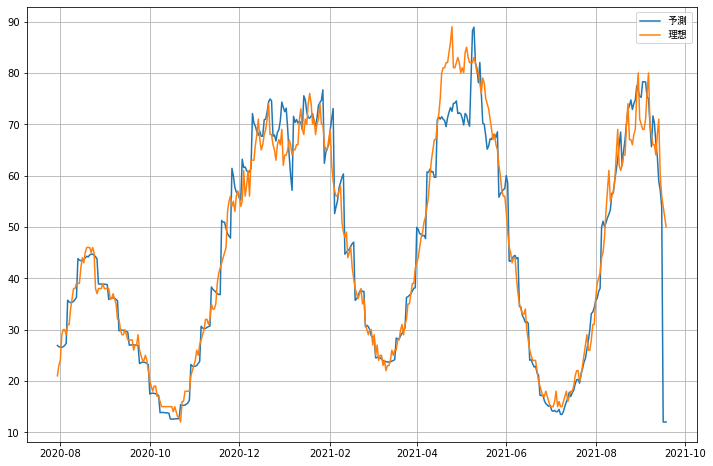

In [318]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(12, 8))
plt.plot(fix_y.index, fix_y[['予測', '理想']])
plt.grid()
plt.legend(labels=['予測', '理想'], prop={"family":"MS Gothic"})
# 目盛のインターバル変更はこれ追加 /（interval=2）の数値をいじる
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.show()

In [319]:
np.mean(mse)

7.700613670870168e-05

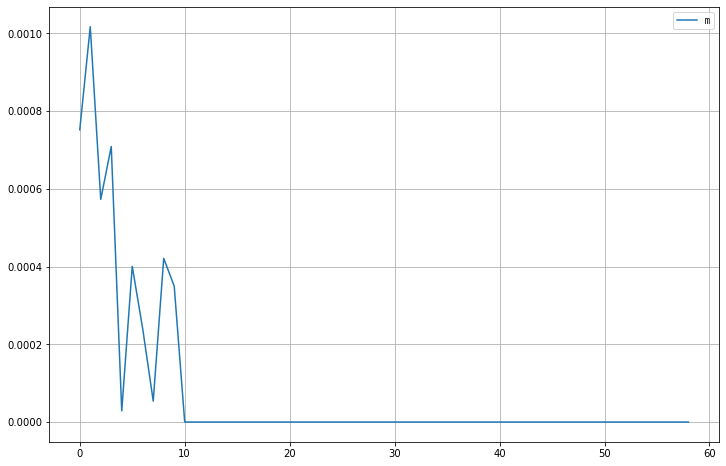

In [320]:
plt.figure(figsize=(12, 8))
plt.plot(mse)
plt.grid()
plt.legend(labels='mse', prop={"family":"MS Gothic"})
plt.show()

# 重みなどの確認

In [321]:
memorized_omega

,week0,week1,week2,week3,week4,week5,week6,week7,week8,week9
0,0.199090,0.315460,0.419308,0.412815,0.347546,0.306627,0.227300,0.193246,0.144880,0.067296
1,-0.012284,0.036847,0.083629,0.097832,0.046853,0.039262,-0.003975,-0.002694,-0.032093,-0.042909
2,-0.002992,0.016340,0.034960,0.040714,0.020714,0.017384,0.000958,0.001929,-0.009479,-0.013643
3,-0.008198,0.037019,0.057619,0.051501,0.022050,0.013340,0.003693,0.000962,0.001562,0.003479
4,0.005210,0.009169,0.011617,0.011271,0.007851,0.007379,0.006758,0.006811,0.006708,0.006795
...,...,...,...,...,...,...,...,...,...,...
724,0.994513,0.994513,0.994513,0.994513,0.994513,0.994513,0.994513,0.994513,0.994513,0.994513
725,0.995885,0.995885,0.995885,0.995885,0.995885,0.995885,0.995885,0.995885,0.995885,0.995885
726,0.997257,0.997257,0.997257,0.997257,0.997257,0.997257,0.997257,0.997257,0.997257,0.997257
727,0.998628,0.998628,0.998628,0.998628,0.998628,0.998628,0.998628,0.998628,0.998628,0.998628


In [322]:
memorized_w

,week0,week1,week2,week3,week4,week5,week6,week7,week8,week9
0,3.986547,3.631177,3.354051,3.452760,3.834813,4.151564,4.401638,4.807944,4.746409,4.881600
1,1.038830,1.024428,1.013216,1.012662,1.015189,1.024223,1.026959,1.009624,1.023828,1.027200
2,1.014512,1.009017,1.004195,1.003646,1.005518,1.008978,1.010217,1.003687,1.008971,1.010175
3,1.037100,1.022313,1.007954,1.004379,1.005141,1.005533,1.008007,1.004698,1.002866,1.001235
4,1.002976,1.001750,1.000596,1.000289,1.000296,1.000356,1.000417,1.000089,1.000096,1.000039
...,...,...,...,...,...,...,...,...,...,...
724,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
725,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
726,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
727,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


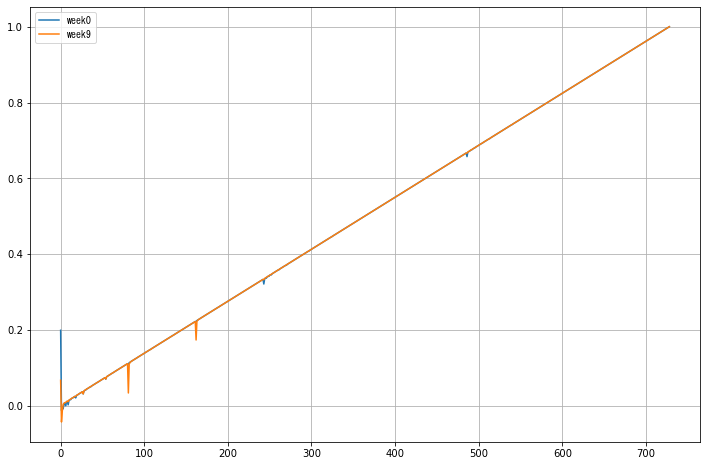

In [323]:
plt.figure(figsize=(12, 8))
plt.plot(memorized_omega[['week0', 'week9']])
plt.grid()
plt.legend(labels=['week0', 'week9'], prop={"family":"MS Gothic"})
plt.show()

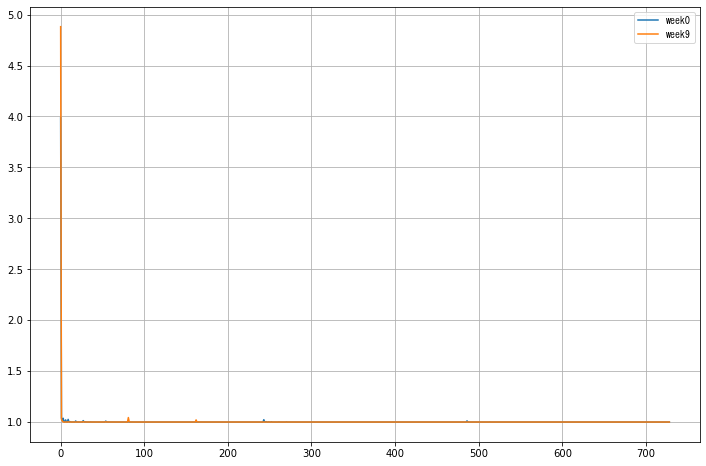

In [324]:
plt.figure(figsize=(12, 8))
plt.plot(memorized_w[['week0', 'week9']])
plt.grid()
plt.legend(labels=['week0', 'week9'], prop={"family":"MS Gothic"})
plt.show()

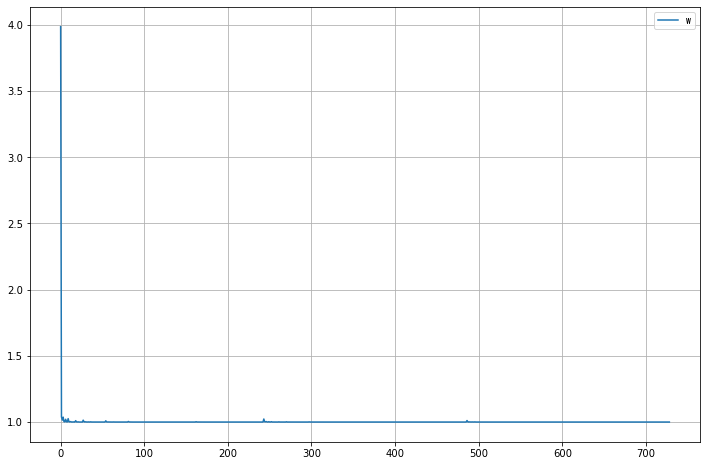

In [325]:
plt.figure(figsize=(12, 8))
plt.plot(memorized_w['week0'])
plt.grid()
plt.legend(labels='week0', prop={"family":"MS Gothic"})
plt.show()

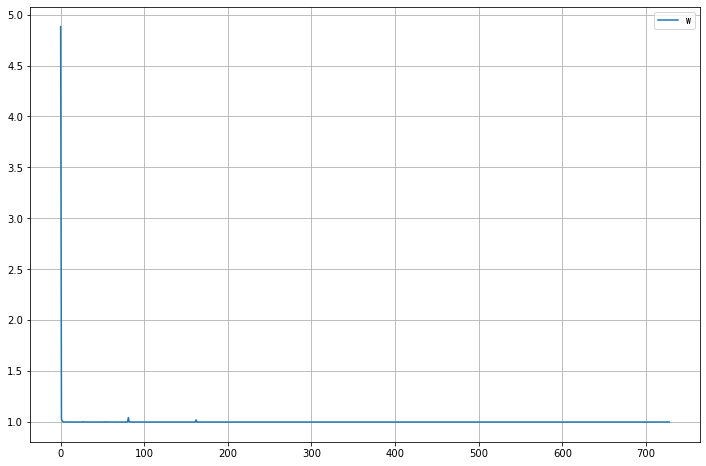

In [326]:
plt.figure(figsize=(12, 8))
plt.plot(memorized_w['week9'])
plt.grid()
plt.legend(labels='week9', prop={"family":"MS Gothic"})
plt.show()